In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from mlxtend.frequent_patterns import apriori, association_rules
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [38]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [39]:
import os

# List contents inside MyDrive
print(os.listdir('/content/gdrive/MyDrive'))

['Colab Notebooks', '.ipynb_checkpoints', 'datasets']


In [40]:
# Load datasets
mall_data = pd.read_csv('/content/gdrive/MyDrive/datasets/Mall_Customers.csv')
retail_data = pd.read_csv('/content/gdrive/MyDrive/datasets/online_retail.csv', encoding='utf-8-sig')

In [41]:
# --- Data Preprocessing for Clustering (Mall Customer Data) ---
# Rename columns for consistency
mall_data.columns = ['CustomerID', 'Gender', 'Age', 'Annual_Income', 'Spending_Score']

In [42]:
# Select features for clustering
X = mall_data[['Age', 'Annual_Income', 'Spending_Score']]

In [43]:
# Encode Gender (if needed for clustering)
mall_data['Gender'] = mall_data['Gender'].map({'Male': 0, 'Female': 1})

In [44]:
# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [45]:
# --- K-means Clustering ---
# Elbow method to find optimal number of clusters
inertia = []
silhouette_scores = []
K = range(2, 10)
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)
    if k > 1:
        silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

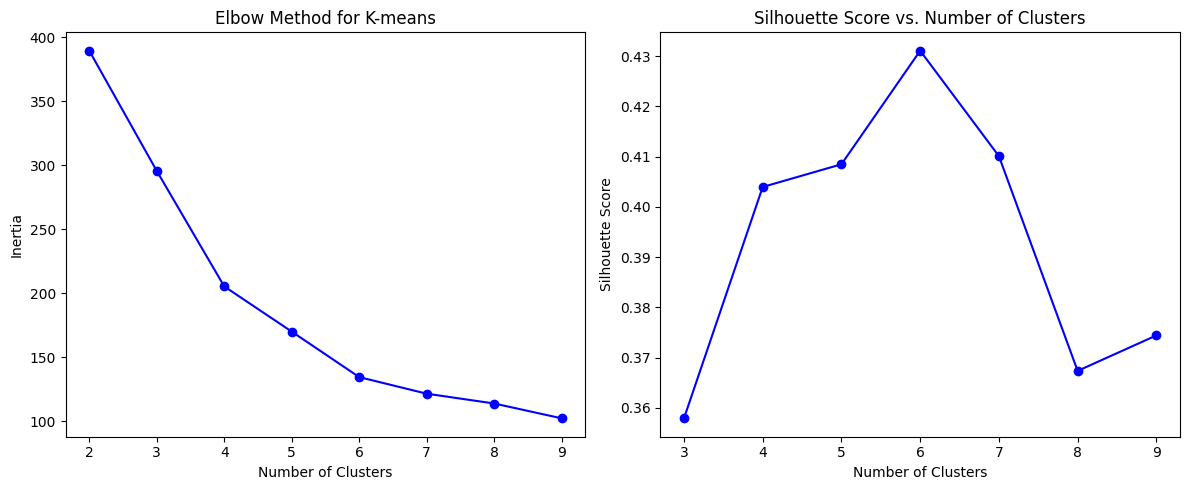

In [46]:
plt.figure(figsize=(12, 5))

# Elbow Plot
plt.subplot(1, 2, 1)
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Elbow Method for K-means')

# Silhouette Plot
plt.subplot(1, 2, 2)
plt.plot(K[1:], silhouette_scores[1:], 'bo-')  # Ensures matching lengths
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Number of Clusters')

plt.tight_layout()
plt.show()

In [47]:
# Apply K-means with optimal clusters (e.g., k=5 based on typical elbow analysis for this dataset)
kmeans = KMeans(n_clusters=5, random_state=42)
mall_data['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

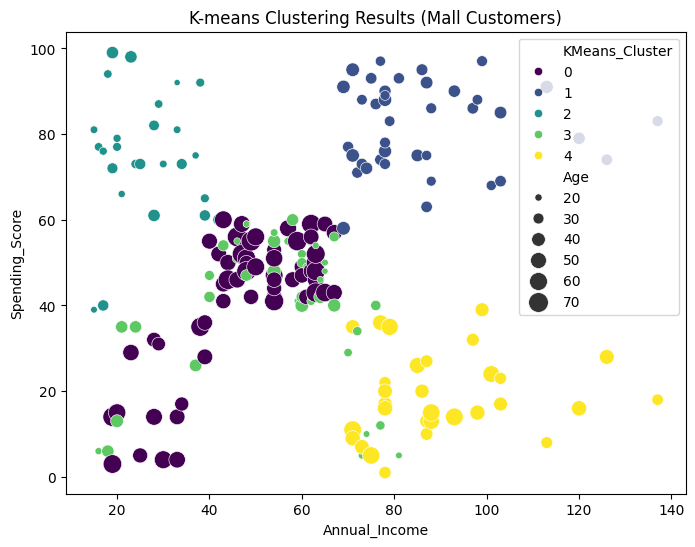

In [48]:
# Visualize K-means clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual_Income', y='Spending_Score', hue='KMeans_Cluster',
                size='Age', sizes=(20, 200), data=mall_data, palette='viridis')
plt.title('K-means Clustering Results (Mall Customers)')
plt.show()

In [49]:
# --- Hierarchical Clustering ---
# Compute linkage matrix
Z = linkage(X_scaled, method='ward')

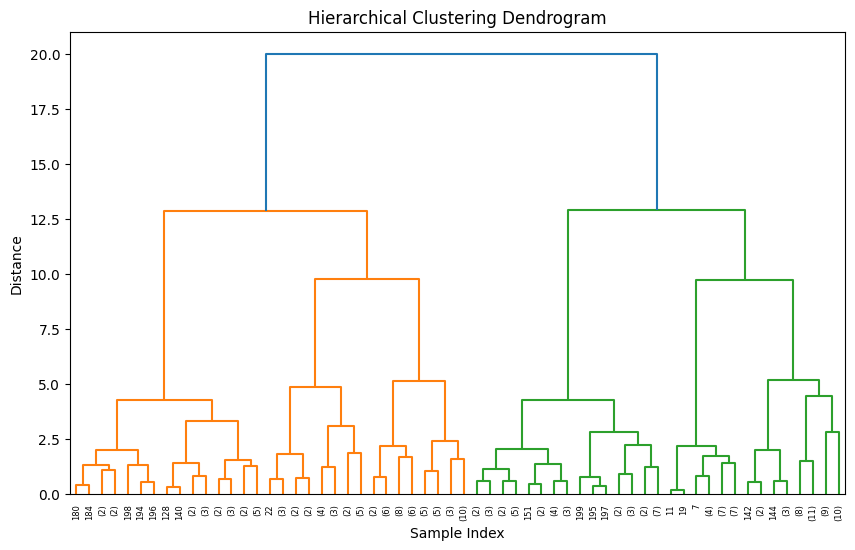

In [50]:
# Plot dendrogram
plt.figure(figsize=(10, 6))
dendrogram(Z, truncate_mode='level', p=5)
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

In [51]:
# Assign clusters (cut at 5 clusters)
mall_data['Hierarchical_Cluster'] = fcluster(Z, t=5, criterion='maxclust')

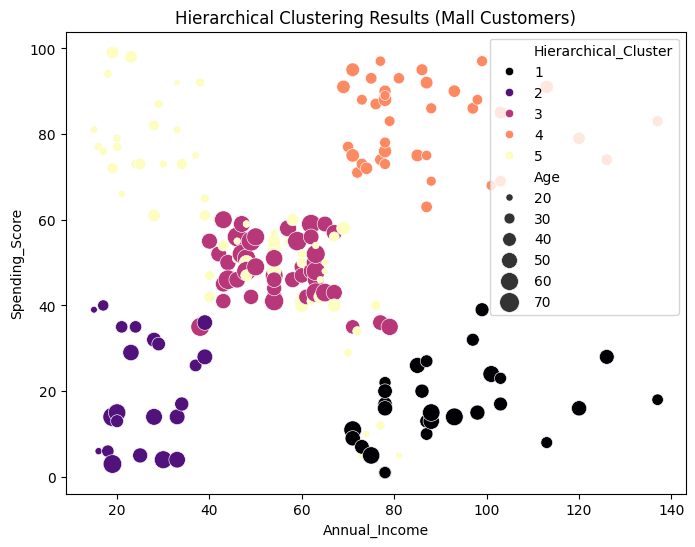

In [52]:
# Visualize Hierarchical clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(x='Annual_Income', y='Spending_Score', hue='Hierarchical_Cluster',
                size='Age', sizes=(20, 200), data=mall_data, palette='magma')
plt.title('Hierarchical Clustering Results (Mall Customers)')
plt.show()

In [53]:
print(retail_data.columns.tolist())

['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate', 'UnitPrice', 'CustomerID', 'Country']


In [54]:
# --- Market Basket Analysis (Online Retail Data) ---
# Preprocess retail data for market basket analysis
retail_data = retail_data.dropna(subset=['InvoiceNo', 'Description'])
retail_data = retail_data[~retail_data['InvoiceNo'].str.contains('C')]  # Remove cancellations

In [55]:
# Create basket matrix (pivot table: invoices vs. items)
basket = retail_data.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().reset_index().fillna(0)
basket = basket.set_index('InvoiceNo')
basket = (basket > 0).astype(bool)  # Convert to binary (0/1)

In [56]:
# Apply Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.03, use_colnames=True)

In [57]:
# Generate association rules
rules = association_rules(frequent_itemsets, metric='lift', min_threshold=1.0)

In [58]:

# Display top 5 rules
print("\nTop 5 Association Rules (Online Retail):")
print(rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']].head())


Top 5 Association Rules (Online Retail):
                          antecedents                        consequents  \
0                    (DOTCOM POSTAGE)          (JUMBO BAG RED RETROSPOT)   
1           (JUMBO BAG RED RETROSPOT)                   (DOTCOM POSTAGE)   
2   (GREEN REGENCY TEACUP AND SAUCER)   (PINK REGENCY TEACUP AND SAUCER)   
3    (PINK REGENCY TEACUP AND SAUCER)  (GREEN REGENCY TEACUP AND SAUCER)   
4  (ROSES REGENCY TEACUP AND SAUCER )  (GREEN REGENCY TEACUP AND SAUCER)   

    support  confidence       lift  
0  0.030246    0.681499   6.563263  
1  0.030246    0.291291   6.563263  
2  0.032325    0.551418  14.223048  
3  0.032325    0.833780  14.223048  
4  0.044382    0.733677  12.515436  


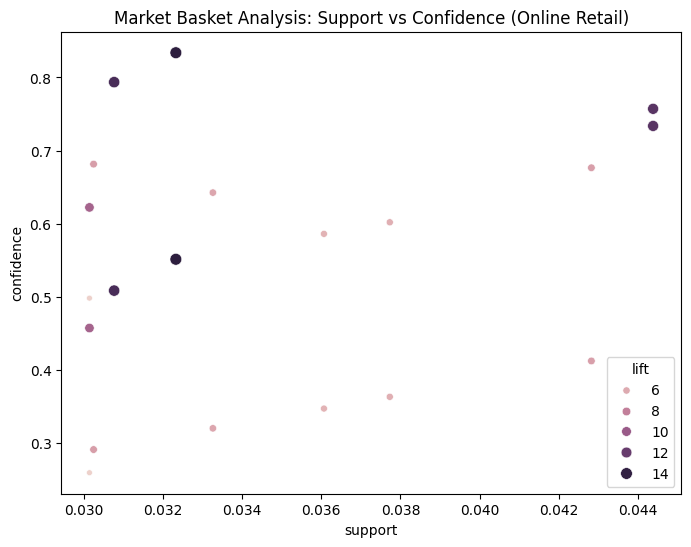

In [59]:
# Visualize support vs confidence
plt.figure(figsize=(8, 6))
sns.scatterplot(x='support', y='confidence', size='lift', hue='lift', data=rules)
plt.title('Market Basket Analysis: Support vs Confidence (Online Retail)')
plt.show()

In [60]:
# --- Cluster Profiles ---
print("\nK-means Cluster Profiles (Mall Customers):")
print(mall_data.groupby('KMeans_Cluster')[['Age', 'Annual_Income', 'Spending_Score']].mean())

print("\nHierarchical Cluster Profiles (Mall Customers):")
print(mall_data.groupby('Hierarchical_Cluster')[['Age', 'Annual_Income', 'Spending_Score']].mean())


K-means Cluster Profiles (Mall Customers):
                      Age  Annual_Income  Spending_Score
KMeans_Cluster                                          
0               55.275862      47.620690       41.706897
1               32.875000      86.100000       81.525000
2               25.769231      26.115385       74.846154
3               26.733333      54.311111       40.911111
4               44.387097      89.774194       18.483871

Hierarchical Cluster Profiles (Mall Customers):
                            Age  Annual_Income  Spending_Score
Hierarchical_Cluster                                          
1                     43.892857      91.285714       16.678571
2                     44.318182      25.772727       20.272727
3                     56.400000      55.288889       48.355556
4                     32.692308      86.538462       82.128205
5                     26.560606      47.363636       56.787879
